In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["mathtext.fontset"] = "custom"

In [3]:
import sympy as sm

fB, fC, fD, a1, a2, N0, N1_a1, N1_a2, N2 = sm.symbols("fA, fB, fC, a1, a2, N0, N1_a1, N1_a2, N2")

fA = 1 - fB - fC - fD

P0 = fA + fB * (1 - 1/a1) + fC * (1 - 1/a1) + fD * (1 - 1/a2)
P1_a1 = fC / a1 + fB * (1/a1 - 1/a2)
P1_a2 = fD / a2
P2 = fB / a2

L = N0 * sm.log(P0) + N1_a1 * sm.log(P1_a1) + N1_a2 * sm.log(P1_a2) + N2 * sm.log(P2)

sys = [
    sm.Eq(sm.simplify(sm.diff(L, fB)), 0),
    sm.Eq(sm.simplify(sm.diff(L, fC)), 0),
    sm.Eq(sm.simplify(sm.diff(L, fD)), 0),
]
sm.simplify(sm.solve(sys, (fB, fC, fD)))

[(N2*a2/(N0 + N1_a1 + N1_a2 + N2), (N1_a1*a1 + N2*a1 - N2*a2)/(N0 + N1_a1 + N1_a2 + N2), N1_a2*a2/(N0 + N1_a1 + N1_a2 + N2))]

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
K = 10000
a1 = 5
a2 = 12
a = np.array([a1, a2])

def simulate(fB_true=0.3, fC_true=0.1, fD_true=0.1):
    cosinc_sim = np.random.uniform(0, 1, K)
    b = a[:, None] * cosinc_sim[None, :]
    obs = (b < 1)
    
    f = np.random.rand(K)
    
    m = (fB_true + fC_true + fD_true) <= f
    obs[:, m] = False
    
    m = ((fB_true + fC_true) <= f) & (f < (fB_true + fC_true + fD_true))
    obs[0, m] = False
    
    m = (fB_true <= f) & (f < (fB_true + fC_true))
    obs[1, m] = False
    
    N_obs = np.sum(obs, axis=0)

    # Treat planets independently
    Na, Nb = np.sum(obs, axis=1)
    Pa = 1. / a1
    Pb = 1. / a2
    occ_a = (Na / Pa + Nb / Pb) / K
    
    # Deal with multiplicity
    bins = -0.5 + np.arange(4)
    N0, N1, N2 = np.histogram(N_obs, bins)[0]
    P0 = 1 - 1. / a1
    P1 = 1. / a1 - 1. / a2
    P2 = 1. / a2
    occ_b = (N1 + N2) / ((1 - P0) * K)
    
    # Fit for multiplicity
    N1_a1 = np.sum((N_obs == 1) & obs[0])
    N1_a2 = np.sum((N_obs == 1) & obs[1])
    fB = N2*a2/K
    fC = (N1_a1*a1 + N2*a1 - N2*a2)/K
    fD = N1_a2*a2/K
    occ_c = fB + fC + fD
    
    return N0, N1, N2, occ_a, occ_b, occ_c

In [6]:
np.random.seed(1234)
sims = np.array([simulate() for k in range(5000)])

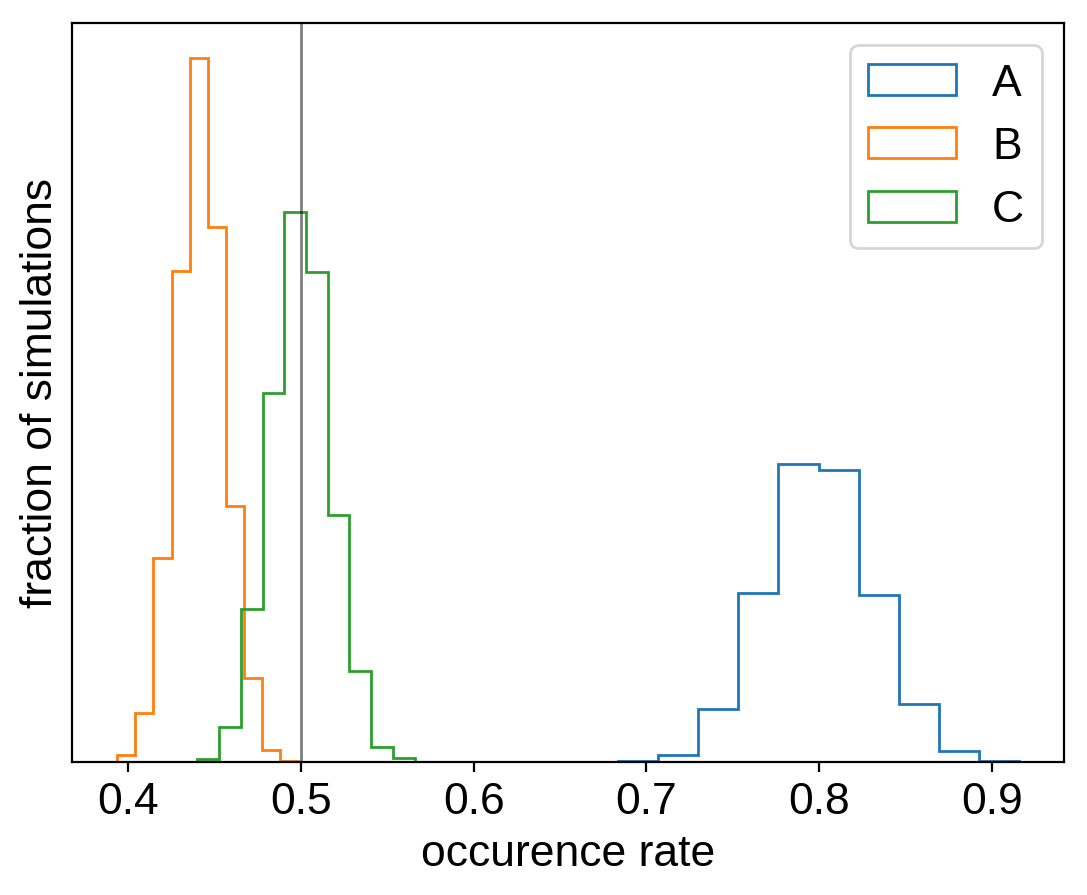

In [16]:
plt.hist(sims[:, -3], density=True, histtype="step", label="A")
plt.hist(sims[:, -2], density=True, histtype="step", label="B")
plt.hist(sims[:, -1], density=True, histtype="step", label="C")
plt.axvline(0.5, color="k", linewidth=1, alpha=0.5)
plt.legend()
plt.xlabel("occurence rate")
plt.ylabel("fraction of simulations")
plt.yticks([])
plt.savefig("simulated.pdf", bbox_inches="tight");